# DEMO: Explaining Groups of Points in Low Dimensional Representations

In this notebook we will go through some toy examples of the approach proposed in [this](https://proceedings.icml.cc/book/2020/hash/ccbd8ca962b80445df1f7f38c57759f0) paper to explain clusters in low dim representations of high dim data.

In [1]:
# imports
import os
import csv
import json
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import numpy as np
import pandas as pd
from sklearn.datasets import load_boston

os.system("rm *.png")

import sys
sys.path.insert(0, "../Code/")
from explain_cs import explain
from load_scvis import load_vae
from misc import poly2labels, load
from metrics import metrics, eval_epsilon, similarity
from myplot import plot_polys, plot_groups, plot_metrics, plot_explanation

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Boston Housing Data

In [2]:
# Load Data

databunch = load_boston()
# x = databunch.data
# y = databunch.target

# minmax scaled boston housing data
x = pd.read_csv("../Housing/Data/X.tsv", sep="\t").values
y = pd.read_csv("../Housing/Data/y.tsv", sep="\t").values

In [3]:
# Load VAE and Clustering Model results from previously run clustering

# cluster definitions
with open("../Housing/vertices.json") as json_file:  
    all_vertices = json.load(json_file)

# metadata
input_dim = x.shape[1]
num_clusters = len(all_vertices)

# path to pretrained vae and func to load it
model_file = "/home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt"
def load_model(input_dim = input_dim, model_file = model_file):
    return load_vae(input_dim, model_file)

In [4]:
# Calculate Data Representation (low dimensional)

sess, rep, X, D = load_model()

data_rep = sess.run(rep, feed_dict={X: x, D: np.zeros((1, input_dim))})




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


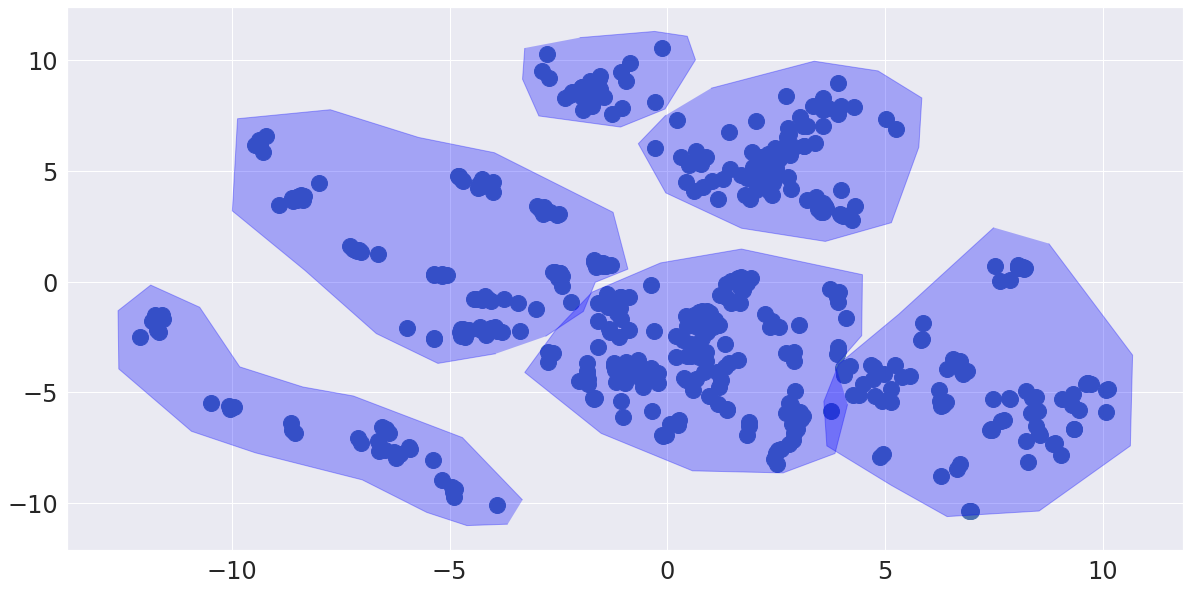

In [5]:
# Visualize the data and the marked clusters

plot_polys(data_rep, all_vertices)

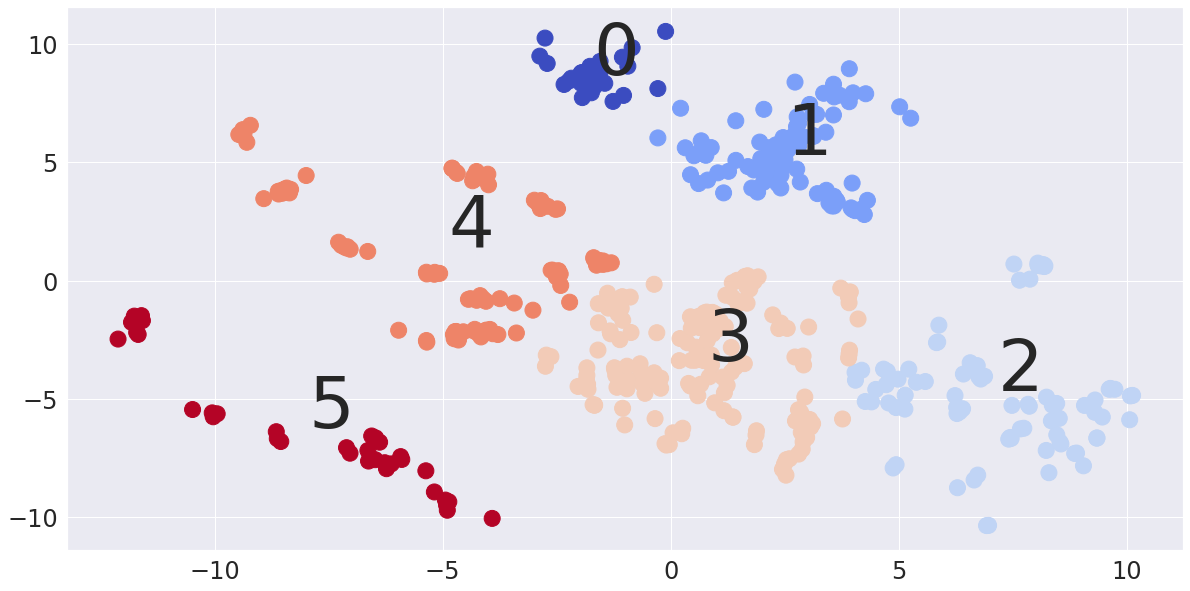

In [6]:
# Visualize the clusters in the learned representation

labels = poly2labels(data_rep, all_vertices)
means, centers, indices = plot_groups(x, data_rep, num_clusters, labels, name = "housing-rep.png")

In [7]:
# Set epsilon for our metrics

# if an "initial + delta" point is within epsilon distance of
# a point in target region, then consider successful mapping
epsilon = 1.5

if True:
    os.system("rm epsilon.txt")
    eval_epsilon(load_model, x, indices, epsilon)


INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


In [8]:
# Init sparsity experiment results matrix
run = False

# Initialize results 
# Columns are:  K, TGT-correctness, TGT-coverage, DBM-correctness, DBM-coverage
# K = [1, 3, 5, 7, 9, 11, 13]
K = [11, 13]
if run:
    os.system("rm *.npy")
    os.system("rm out.csv")
    
    out = np.zeros((len(K), 5))

    c = 0
    for k in K:
        out[c, 0] = k
        c += 1

In [9]:
# Evaluate DBM 

if run:
    exp_mean = np.zeros((num_clusters - 1, input_dim))
    for i in range(num_clusters - 1):
        exp_mean[i, :] = means[i + 1] - means[0]

    c = 0
    for k in K:
        a, b = metrics(load_model, x, indices, exp_mean, epsilon, k = k)

        out[c, 3] = np.mean(a)
        out[c, 4] = np.mean(b)

        c += 1

In [10]:
# Evaluate the group explanations (ELDR) at each of a range of sparsities

if run:

    c = 0
    for k in tqdm(K):

        best_val = 0.0
        for lg in tqdm([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]):
            for trial in range(5):

                deltas = explain(load_model, means, centers, learning_rate = 0.01, consecutive_steps = 5, lambda_global = lg)
                a, b = metrics(load_model, x, indices, deltas, epsilon, k = k) 

                val = np.mean(a)

                if val > best_val:
                    best_val = val
                    out[c, 1] = best_val
                    out[c, 2] = np.mean(b)
                    np.save("deltas" + str(k) + ".npy", deltas)

                os.system("rm -rf explanation")

        c += 1

In [11]:
# Save results
if run:
    np.savetxt("out.csv", out, delimiter = ",")
else:
    out = np.loadtxt("out.csv", delimiter = ",")
    
print(out)

[[11.          0.92230378  0.77794989  0.88108726  0.80676594]
 [13.          0.92995609  0.78080884  0.88155791  0.80659014]]


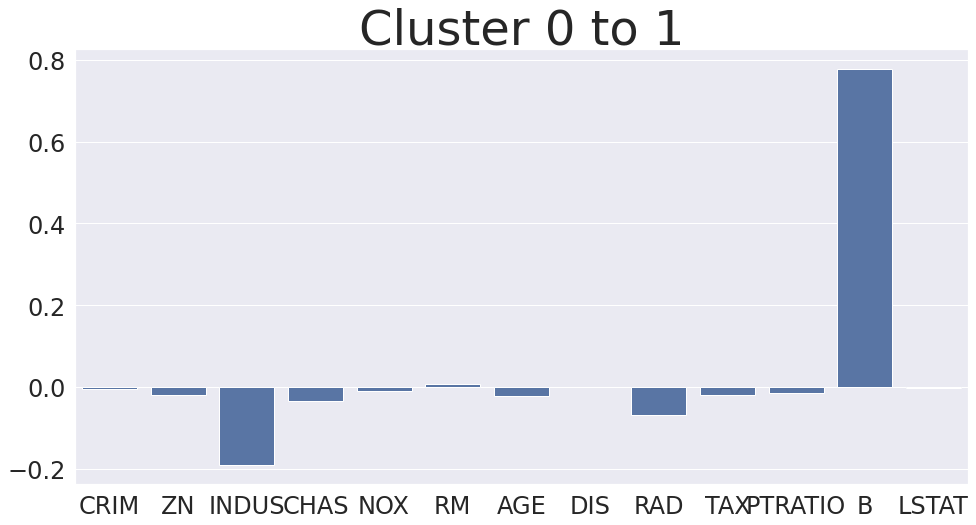

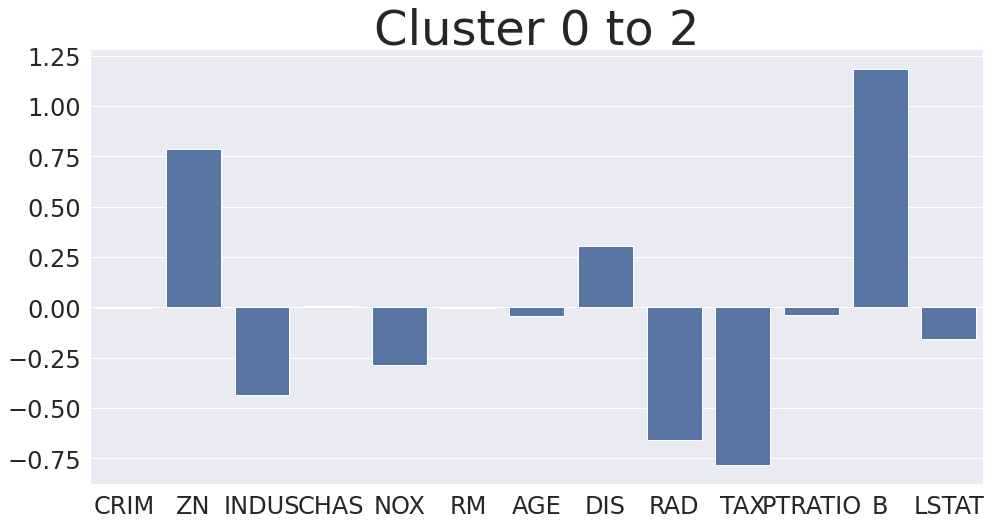

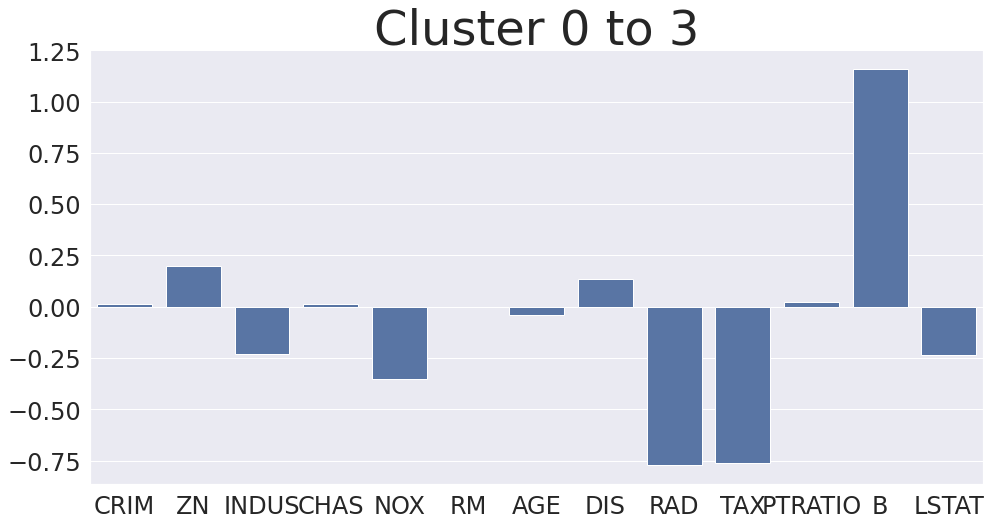

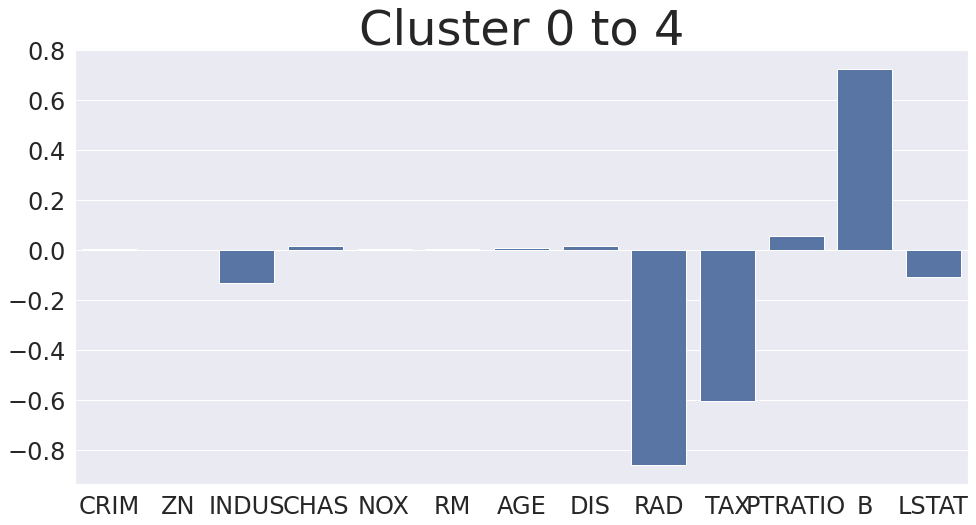

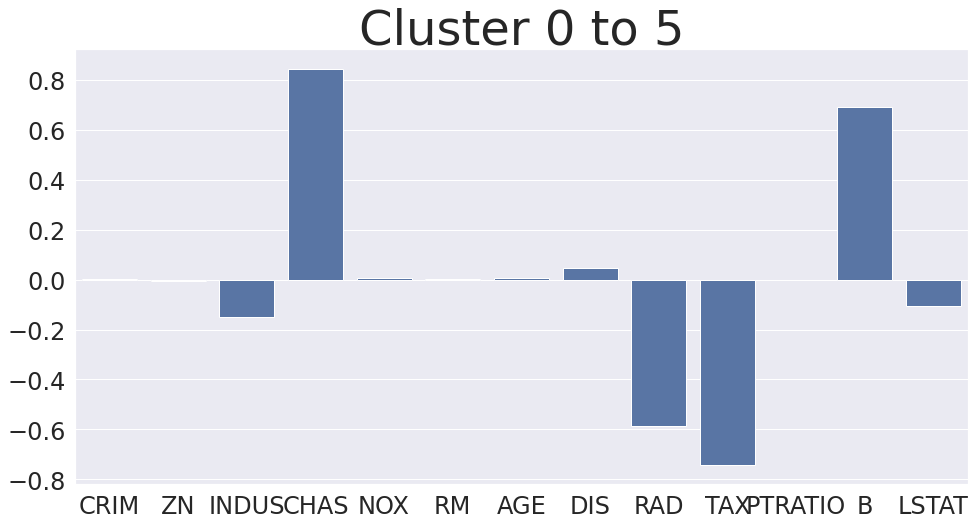

In [12]:
# plot deltas
deltas = np.load('deltas13.npy')
for i in range(len(deltas)):
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.barplot(x=databunch.feature_names, y=deltas[i], ax=ax, color='b')
    plt.title(f'Cluster 0 to {i+1}')
    plt.show()

In [13]:
# take data points from group 0 and add delta 1 to make them into region 1

sess, rep, X, D = load_model()

INITIAL_GROUP = 0
TARGET_GROUP = 4

if INITIAL_GROUP == 0:
    d = deltas[TARGET_GROUP - 1]
elif TARGET_GROUP == 0:
    d = -1.0 * deltas[INITIAL_GROUP - 1]
else:
    d = -1.0 * deltas[INITIAL_GROUP - 1] + deltas[TARGET_GROUP - 1]

# take points from initial group and apply delta
x_init_transf = x[labels==INITIAL_GROUP] + d

# get low dim repr of initial + delta (i.e. transformed initial pts)
x_init_transf_lowdim = sess.run(rep, feed_dict={X: x_init_transf, D: np.zeros((1, input_dim))})

# what group did the clustering algo classify these to
x_init_transf_lowdim_labels = poly2labels(x_init_transf_lowdim, all_vertices)
x_init_transf_lowdim_labels

INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4.])

## Single-cell RNA dataset

In [14]:
# Load Data (and approximate it??)

# pre saved single cell rna data
x = pd.read_csv("../Bipolar/Data/bipolar_rep_scaled.tsv", sep="\t").values

# Approximate the original data
pc_matrix_file = "/home/kachau/Documents/ELDR/Bipolar/Data/bipolar_pc.tsv"
matrix = pd.read_csv(pc_matrix_file, sep = "\t", header = None).values

x_full = np.matmul(x, np.transpose(matrix))

In [15]:
# Load VAE and Clustering Model results from previously run clustering

# cluster definitions
with open("../Bipolar/vertices.json") as json_file:  
    all_vertices = json.load(json_file)

# metadata
input_dim = x_full.shape[1]
num_clusters = len(all_vertices)

# path to pretrained vae and func to load it
model_file = "/home/kachau/Documents/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt"
def load_model(input_dim = input_dim, model_file = model_file):
    return load_vae(input_dim, model_file, feature_transform = pc_matrix_file)

In [16]:
# Calculate Data Representation (low dimensional)

sess, rep, X, D = load_model()

data_rep = sess.run(rep, feed_dict={X: x_full, D: np.zeros((1, input_dim))})

INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


In [17]:
# plot settings for larger number of points
matplotlib.rc("lines", markersize = 4)# Override some default plot parameters

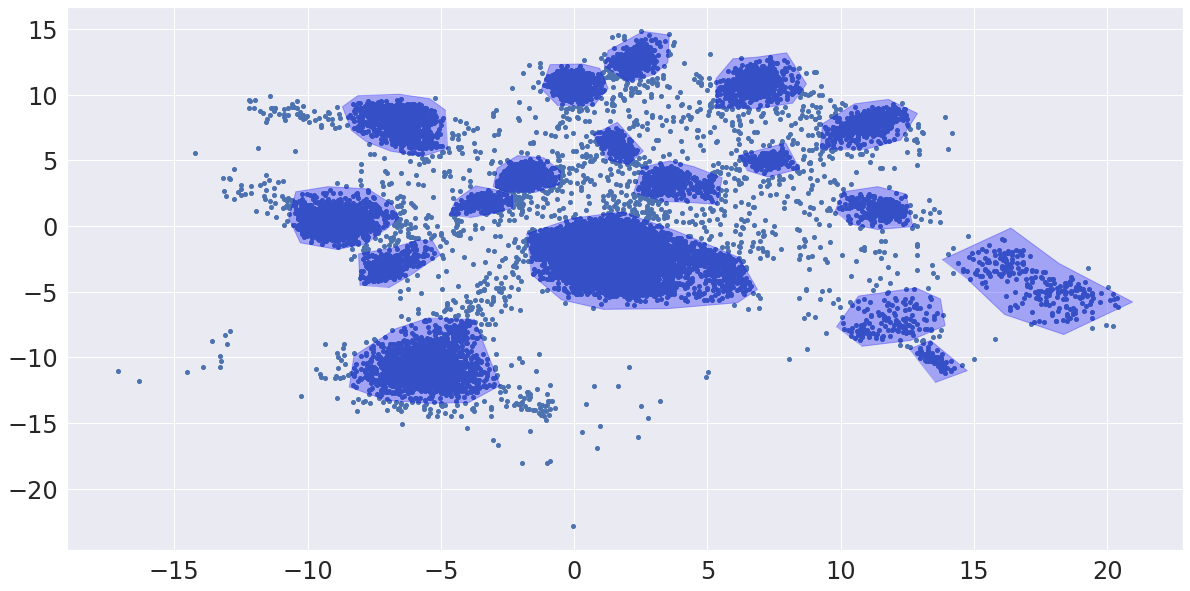

In [18]:
# Visualize the data and the marked clusters
plot_polys(data_rep, all_vertices)

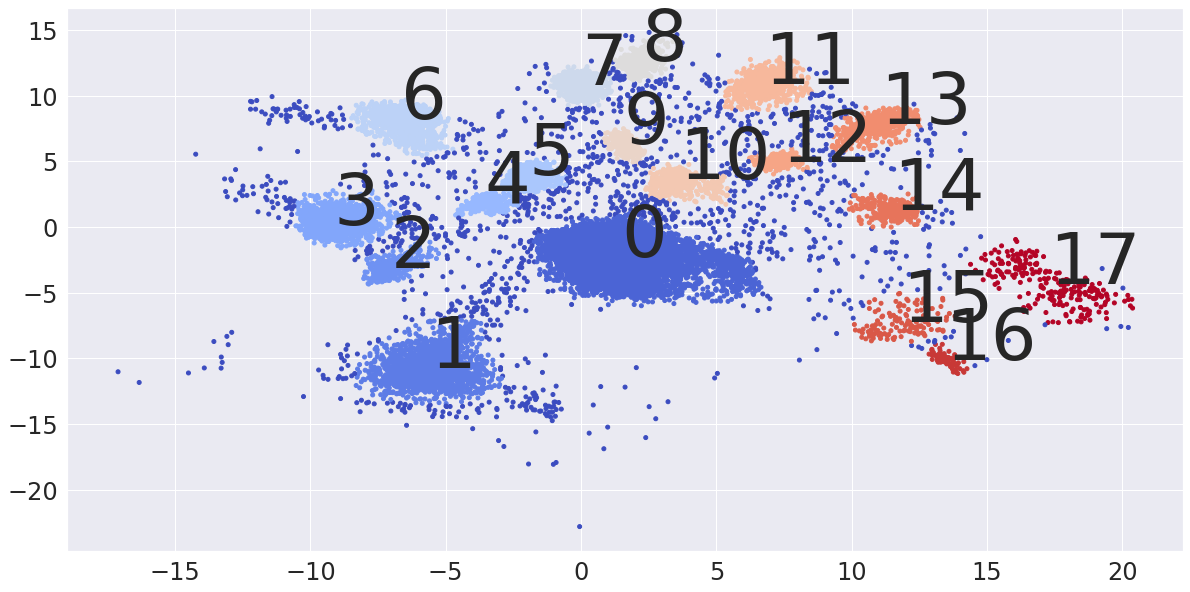

In [19]:
# Visualize the clusters in the learned representation

labels = poly2labels(data_rep, all_vertices)

means, centers, indices = plot_groups(x_full, data_rep, num_clusters, labels, name = "bipolar-rep.png")

In [20]:
# Select a subset of the data to use to select the hyper parameters

frac = 0.25

n = x_full.shape[0]

chosen = np.random.choice(n, int(frac * n), replace = False)

x_val = x_full[chosen, :]

indices_val = [[]] * num_clusters
for i in range(num_clusters):
    indices_val[i] = []
    for j in range(int(frac * n)):
        if labels[chosen[j]] == i:
            indices_val[i].append(j)

In [21]:
# Set epsilon for our metrics

epsilon = 0.75

if False:
    os.system("rm epsilon.txt")
    eval_epsilon(load_model, x_full, indices, epsilon)

In [22]:
# Init sparsity effect experiment
run = False

# Initialize results 
# Columns are:  K, TGT-correctness, TGT-coverage, DBM-correctness, DBM-coverage
K = [50, 100, 250, 500, 1000, 15000]
if run:
    os.system("rm *.npy")
    os.system("rm out.csv")
    
    out = np.zeros((len(K), 5))

    c = 0
    for k in K:
        out[c, 0] = k
        c += 1

In [23]:
# Compute the group explanations at each of a range of sparsities

if run:

    c = 0
    for k in K:

        # Search for the best setting using a subset of the data for evaluation
        best_val = 0.0
        for lg in [0.0, 300, 625, 1250, 2500]:
            for trial in range(5):

                deltas = explain(load_model, means, centers, learning_rate = 0.0005, consecutive_steps = 5, lambda_global = lg)
                a, b = metrics(load_model, x_val, indices_val, deltas, epsilon, k = k)

                val = np.mean(a)

                if val > best_val:
                    best_val = val
                    np.save("deltas" + str(k) + ".npy", deltas)

                os.system("rm -rf explanation")
                
        # Evaluate the best configuration on the full data
        deltas = np.load("deltas" + str(k) + ".npy")
        a, b = metrics(load_model, x_full, indices, deltas, epsilon, k = k)
        out[c, 1] = np.mean(a)
        out[c, 2] = np.mean(b)

        c += 1

In [24]:
# Evaluate DBM 

if run:
    exp_mean = np.zeros((num_clusters - 1, input_dim))
    for i in range(num_clusters - 1):
        exp_mean[i, :] = means[i + 1] - means[0]

    c = 0
    for k in K:
        a, b = metrics(load_model, x_full, indices, exp_mean, epsilon, k = k)

        out[c, 3] = np.mean(a)
        out[c, 4] = np.mean(b)

        c += 1
    

In [27]:
# Save results
if run:
    np.savetxt("../Bipolar-K/out.csv", out, delimiter = ",")
else:
    out = np.loadtxt("../Bipolar-K/out.csv", delimiter = ",")
    
print(out)


[[5.00000000e+01 6.57893007e-01 8.73317205e-01 1.62936889e-01
  4.11480263e-01]
 [1.00000000e+02 7.67844634e-01 9.34122105e-01 2.70437013e-01
  6.25504510e-01]
 [2.50000000e+02 8.34456050e-01 9.44577985e-01 5.68996355e-01
  8.45189585e-01]
 [5.00000000e+02 8.71103497e-01 9.54701862e-01 7.77121105e-01
  9.15699715e-01]
 [1.00000000e+03 8.98954230e-01 9.61301664e-01 8.72913239e-01
  9.46999865e-01]
 [1.50000000e+04 9.06553527e-01 9.62557846e-01 9.51651164e-01
  9.56013157e-01]]


In [56]:
# Load results
deltas = np.load('../Bipolar-K/deltas50.npy')

In [77]:
# take data points from group 0 and add delta 1 to make them into region 1

sess, rep, X, D = load_model()

INITIAL_GROUP = 1
TARGET_GROUP = 15

if INITIAL_GROUP == 0:
    d = deltas[TARGET_GROUP - 1]
elif TARGET_GROUP == 0:
    d = -1.0 * deltas[INITIAL_GROUP - 1]
else:
    d = -1.0 * deltas[INITIAL_GROUP - 1] + deltas[TARGET_GROUP - 1]

# take points from initial group and apply delta
x_full_init_transf = x_full[labels==INITIAL_GROUP] + d

# get low dim repr of initial + delta (i.e. transformed initial pts)
x_full_init_transf_lowdim = sess.run(rep, feed_dict={X: x_full_init_transf, D: np.zeros((1, input_dim))})

# what group did the clustering algo classify these to
x_full_init_transf_lowdim_labels = poly2labels(x_full_init_transf_lowdim, all_vertices)

# pretty print
res = pd.Series(x_full_init_transf_lowdim_labels).value_counts().to_frame('count')
res.index.name = 'group_id'
res

INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


,count
group_id,
15.0,2950
-1.0,28
16.0,1
